In [1]:
from yamlscript_histdata import histdata_parser
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import numpy as np
import mplhep as hep
import boost_histogram as bh
from plot_classes import EmptyPlot

In [2]:
df1, df2 = histdata_parser("CR_ttc_prefit.yaml")

histdata_parser ran in 55 ms.


In [3]:
df2

,0
BinEdges,"[0, 0.2596, 0.2928, 0.3119, 0.3279999999999999..."
XaxisLabel,BDT(t#bar{t} + #geq1c)
YaxisLabel,


In [4]:
dflist          = df1.loc[['Samples']]
hist_list       = list(reversed(df1.loc[['Samples'], 'Yield'].tolist()))
histlist_edges  = df2.loc[['BinEdges'],0][0]
histlist_labels = ['$' + x.replace('#', '\\') + '$' for x in reversed(dflist.index.get_level_values(1).tolist())]
total_yield     = df1.loc[['Total'],'Yield'][0]
data_yield      = df1.loc[['Data'],'Yield'][0]
total_errup     = df1.loc[['Total'],'Yield'][1]
total_errdown   = df1.loc[['Total'],'Yield'][2]
xaxis_label     = '$' + df2.loc[['XaxisLabel'], 0][0].replace('#', '\\') + '$'

In [5]:
total_errdown

[-827.5826665452911,
 -805.426846012266,
 -826.1614268385684,
 -826.1363081308623,
 -840.6187776963856,
 -849.9563379690394,
 -863.3908776550447,
 -871.4519829633153,
 -878.3093688851706,
 -867.5428671883344]

In [12]:
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

        

class PythRatio(EmptyPlot):
    
    def __init__(self, toptitle=None, bottitle=None, topylabel="Events", botylabel="Data/Pred.", **kwargs):
        
        super().__init__(layout=(2,1), **kwargs)
        
        ### these should be retrived from filled object -------------
        self.dflist          = dflist
        self.histlistedges   = histlist_edges
        self.histlisttotal   = total_yield
        self.histlistdata    = data_yield
        self.histlistlabels  = histlist_labels
        self.histlisterrup   = total_errup
        self.histlisterrdown = total_errdown
        self.histlistxlabel  = xaxis_label
        ### ---------------------------------------------------------
        
        self.create_canvas()
        self.make_grid(hspace=0.02, height_ratios=[4,1])
        self.topax = self.make_subplot(0, 1, 0, 1)
        self.botax = self.make_subplot(1, 2, 0, 1)
        self.toptitle = toptitle
        self.bottitle = bottitle
        self.topylabel = topylabel
        self.botylabel = botylabel
        self.set_stack_color() # set default colormap
        
        # the lower part in the ratio plot is the data divided by the total hist cont
        self.ratiovalues = [i/j for i, j in zip(self.histlistdata, self.histlisttotal)]
        
        # set rcParams for the plot
        mpl.rcParams['legend.columnspacing'] = 0.5
        mpl.rcParams['legend.labelspacing']  = 0.1
        mpl.rcParams['legend.loc']           = 'upper right'
        mpl.rcParams['legend.markerscale']   = 1.2
        mpl.rcParams['legend.handletextpad'] = 0.15
        mpl.rcParams['legend.fontsize']      = 15

    def fill(self, obj): # put in the figure histogram object(s)
        self.container1d.append(obj)
        
    def display(self, save=False):
        
        ### overall figure ###
        self.fig.suptitle(self.title)
        
        ### top figure ###
        
        # ===== stacked histogram =====
        hep.histplot(self.container1d[0], ax=self.topax, bins=self.histlistedges, stack=True, fill=True, 
                     label=self.histlistlabels, color=self.colorlist, edgecolor='k')
        # ===== data scatter points =====
        hep.histplot(self.histlistdata, ax=self.topax, bins=self.histlistedges, histtype='errorbar', color='k', 
                     label="Data", markersize=15)
        # ===== data error histograms =====
        self.topax.stairs(self.histlisttotal, edges=self.histlistedges, color='k', alpha=0.3, hatch='///', label="Uncertainty", 
                          baseline=[self.histlisttotal[i] + self.histlisterrup[i] for i in range(len(self.histlisttotal))])
        self.topax.stairs(self.histlisttotal, edges=self.histlistedges, color='k', alpha=0.3, hatch='///',
                          baseline=[self.histlisttotal[i] + self.histlisterrdown[i] for i in range(len(self.histlisttotal))])
        
        # ===== customisations =====
        self.set_majorticks(self.topax, direction='in', length=10, bottom=True, top=True, left=True, right=True)
        self.set_minorticks(self.topax, direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        self.topax.ticklabel_format(style='plain')
        self.topax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        self.topax.set_xticklabels([])
        # self.topax.set_ylim([0, 12_000])
        self.topax.set_title(self.toptitle)
        self.topax.set_ylabel(self.topylabel)
        self.topax.legend(ncol=2, handlelength=1.7)
        # self.topax.legend([main[0]], ["ciaooo"], handler_map={main[0]: HandlerSquare()}, ncol=2, handlelength=1.7)
        hep.atlas.label(ax=self.topax, label="Internal", data=True, lumi=139)

        ### bot figure ###

        hep.histplot(self.ratiovalues, ax=self.botax, bins=self.histlistedges, histtype='errorbar', color='k', markersize=15)
        # ===== data error histograms =====
        self.histlisterrup_ratio = [(self.histlisttotal[i] + self.histlisterrup[i])/self.histlisttotal[i] for i in range(len(self.histlisttotal))]
        self.histlisterrdown_ratio = [(self.histlisttotal[i] + self.histlisterrdown[i])/self.histlisttotal[i] for i in range(len(self.histlisttotal))]
        self.botax.stairs(self.histlisterrup_ratio, edges=self.histlistedges, color='k', alpha=0.3, hatch='///', baseline=1)
        self.botax.stairs(self.histlisterrdown_ratio, edges=self.histlistedges, color='k', alpha=0.3, hatch='///', baseline=1)
        
        # ===== customisations =====
        self.set_majorticks(self.botax, direction='in', length=10, bottom=True, top=True, left=True, right=True)
        self.set_minorticks(self.botax, direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        self.botax.set_ylim([0.5, 1.5])
        self.botax.axhline(1, color='k', linestyle='--')
        self.botax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        self.botax.set_yticklabels(["0.5", "0.75", "1.00", "1.25", ""])
        self.botax.set_yticks([0.5, 0.75, 1, 1.25, 1.5])
        self.botax.set_ylabel(self.botylabel)
        self.botax.set_xlabel(self.histlistxlabel)
        self.botax.set_title(self.bottitle)
        
        hep.plot.yscale_legend(ax=self.topax) # scale ylim automatically for optimal legend placement
        
        if save:
            self.saveimage(type(self).__name__)

/tmp/flciciri/ipykernel_32637/1845947502.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.botax.set_yticklabels(["0.5", "0.75", "1.00", "1.25", ""])


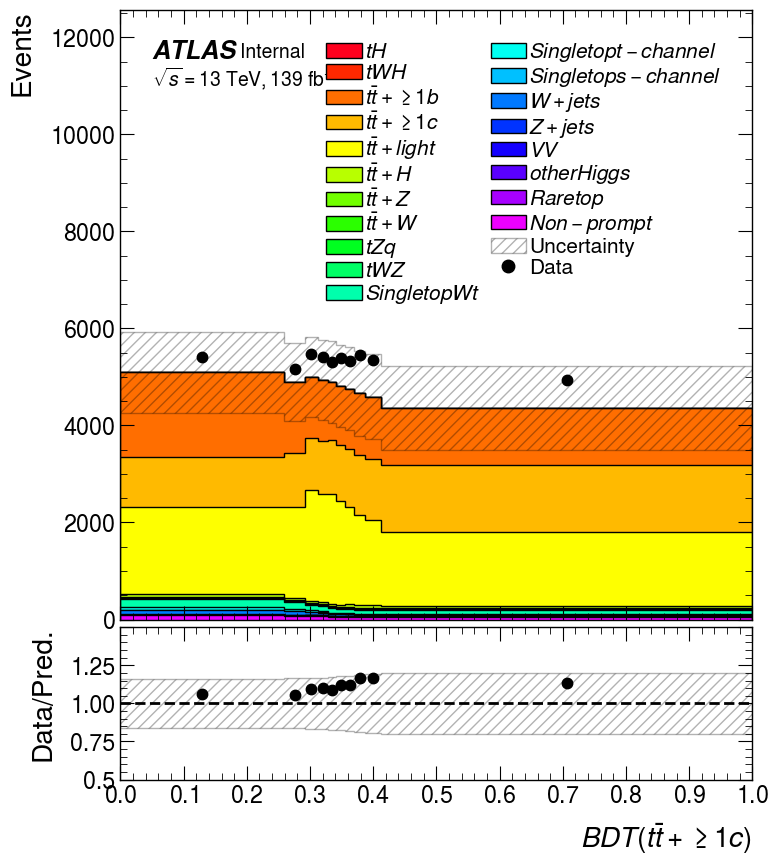

In [11]:
obj1 = PythRatio(size=(8,10))
obj1.fill(hist_list)
obj1.set_stack_color(reverse=True, colormap="gist_rainbow")
obj1.display()